In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.filters.hp_filter as hpfilter
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
start_year = 1970
end_year = 2023
year_obs = end_year - start_year +1
dfFullData = pd.read_excel('MainSpreadsheet/CombinedData.xlsx',index_col=0)
country_code = sorted(list(set(dfFullData['NAM'])))

In [3]:
# REG_SKIP = REG but skip the first three years of switchning to new regime

dfFullData.insert(dfFullData.columns.get_loc('REG') + 1,'REG_SKIP',dfFullData['REG'])
dfRegSkip1 = dfFullData['REG'].ne(dfFullData['REG'].shift(1)) & (dfFullData['YRS']!=start_year)
dfRegSkip2 = dfFullData['REG'].ne(dfFullData['REG'].shift(2)) & (dfFullData['YRS']!=start_year) & (dfFullData['YRS']!=start_year+1) 
dfRegSkip3 = dfFullData['REG'].ne(dfFullData['REG'].shift(3)) & (dfFullData['YRS']!=start_year) & (dfFullData['YRS']!=start_year+1) & (dfFullData['YRS']!=start_year+2)  

dfFullData.loc[dfRegSkip1 | dfRegSkip2 | dfRegSkip3,'REG_SKIP'] = np.nan

dfFullData.loc[:,['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']] = 0
dfFullData.loc[dfFullData['REG_SKIP'] == 1, 'dumDOLLAR_SKIP'] = 1
dfFullData.loc[dfFullData['REG_SKIP'] == 2, 'dumCURRENCYBOARD_SKIP'] = 1
dfFullData.loc[dfFullData['REG_SKIP'] == 3, 'dumPEGGED_SKIP'] = 1
dfFullData.loc[dfFullData['REG_SKIP'] == 4, 'dumINTERMEDIATE_SKIP'] = 1
dfFullData.loc[(dfFullData['REG_SKIP'] == 5) | (dfFullData['REG_SKIP'] == 6), 'dumFLEXIBLE_SKIP'] = 1
dfFullData

,NAM,YRS,REG,REG_SKIP,NGDP_R,NGDP_R_HP,NGDP_R_LN,NGDP_R_LN_GAP,NGDP_R_LN_HP,NGDP_RPCH,...,dumDOLLAR,dumCURRENCYBOARD,dumPEGGED,dumINTERMEDIATE,dumFLEXIBLE,dumDOLLAR_SKIP,dumCURRENCYBOARD_SKIP,dumPEGGED_SKIP,dumINTERMEDIATE_SKIP,dumFLEXIBLE_SKIP
0,111,1970,3.0,3.0,5316.3913,5337.804633,8.578550,0.011509,8.590059,NaN,...,0,0,1,0,0,0,0,1,0,0
1,111,1971,3.0,3.0,5491.4455,5524.546653,8.610947,0.010061,8.621008,3.292726,...,0,0,1,0,0,0,0,1,0,0
2,111,1972,3.0,3.0,5780.0483,5711.074540,8.662167,-0.010326,8.651841,5.255498,...,0,0,1,0,0,0,0,1,0,0
3,111,1973,5.0,NaN,6106.3705,5896.843149,8.717088,-0.034744,8.682343,5.645666,...,0,0,0,0,1,0,0,0,0,0
4,111,1974,5.0,NaN,6073.3628,6081.997072,8.711668,0.000735,8.712403,-0.540545,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10579,968,2019,4.0,NaN,873.1830,NaN,6.772145,NaN,NaN,3.853000,...,0,0,0,1,0,0,0,0,0,0
10580,968,2020,4.0,NaN,841.0720,NaN,6.734677,NaN,NaN,-3.677000,...,0,0,0,1,0,0,0,0,0,0
10581,968,2021,4.0,NaN,889.0880,NaN,6.790196,NaN,NaN,5.709000,...,0,0,0,1,0,0,0,0,0,0
10582,968,2022,4.0,4.0,929.9450,NaN,6.835125,NaN,NaN,4.595000,...,0,0,0,1,0,0,0,0,1,0


In [4]:
# Create a variable of 1-year-lagged changes in terms of trade

dfFullData['TTPCH.L1'] = dfFullData['TTPCH'].shift(1)
dfFullData.loc[dfFullData['YRS'] == start_year,'TTPCH.L1'] = np.nan

In [5]:
# Create dummy variables of when countries switch to another exchange rate regimes

dfFullData.insert(dfFullData.columns.get_loc('dumCURRENCYBOARD')+1,'dumAfterCURRENCYBOARD',0)
dfFullData['dumAfterCURRENCYBOARD'] += (dfFullData['dumCURRENCYBOARD'].shift(1)-dfFullData['dumCURRENCYBOARD']).clip(lower=0)
dfFullData['dumAfterCURRENCYBOARD'] += dfFullData['dumAfterCURRENCYBOARD'].shift(1) + dfFullData['dumAfterCURRENCYBOARD'].shift(2)+\
dfFullData['dumAfterCURRENCYBOARD'].shift(3)+ dfFullData['dumAfterCURRENCYBOARD'].shift(4)
dfFullData['dumAfterCURRENCYBOARD'] = dfFullData['dumAfterCURRENCYBOARD'].clip(upper=1)
dfFullData.loc[dfFullData['YRS']<=start_year+5,'dumAfterCURRENCYBOARD'] = 0


dfFullData.insert(dfFullData.columns.get_loc('dumCURRENCYBOARD')+1,'dumBeforeCURRENCYBOARD',0)
dfFullData['dumBeforeCURRENCYBOARD'] += (dfFullData['dumCURRENCYBOARD'].shift(-1)-dfFullData['dumCURRENCYBOARD']).clip(lower=0)
dfFullData['dumBeforeCURRENCYBOARD'] += dfFullData['dumBeforeCURRENCYBOARD'].shift(-1) + dfFullData['dumBeforeCURRENCYBOARD'].shift(-2)
dfFullData['dumBeforeCURRENCYBOARD'] = dfFullData['dumBeforeCURRENCYBOARD'].clip(upper=1)
dfFullData.loc[dfFullData['YRS']>=end_year-2,'dumBeforeCURRENCYBOARD'] = 0

dfFullData.insert(dfFullData.columns.get_loc('dumCURRENCYBOARD')+1,'dumFinalCURRENCYBOARD',0)
dfFullData['dumFinalCURRENCYBOARD'] += (dfFullData['dumCURRENCYBOARD']-dfFullData['dumCURRENCYBOARD'].shift(-1)).clip(lower=0)
dfFullData['dumFinalCURRENCYBOARD'] += dfFullData['dumFinalCURRENCYBOARD'].shift(-1) + dfFullData['dumFinalCURRENCYBOARD'].shift(-2)
dfFullData['dumFinalCURRENCYBOARD'] = dfFullData['dumFinalCURRENCYBOARD'].clip(upper=1)
dfFullData.loc[(dfFullData['YRS']>=end_year-2)&(dfFullData['dumCURRENCYBOARD']==1),'dumFinalCURRENCYBOARD'] = 1
dfFullData.loc[(dfFullData['YRS']<=start_year+2)&(dfFullData['dumCURRENCYBOARD']==1),'dumBeforeCURRENCYBOARD'] = 1

dfFullData.insert(dfFullData.columns.get_loc('dumDOLLAR')+1,'dumBeforeDOLLAR',0)
dfFullData['dumBeforeDOLLAR'] += (dfFullData['dumDOLLAR'].shift(-1)-dfFullData['dumDOLLAR']).clip(lower=0)
dfFullData['dumBeforeDOLLAR'] += dfFullData['dumBeforeDOLLAR'].shift(-1) + dfFullData['dumBeforeDOLLAR'].shift(-2)
dfFullData['dumBeforeDOLLAR'] = dfFullData['dumBeforeDOLLAR'].clip(upper=1)
dfFullData.loc[dfFullData['YRS']>=end_year-2,'dumBeforeDOLLAR'] = 0

dfFullData.insert(dfFullData.columns.get_loc('dumDOLLAR')+1,'dumFinalDOLLAR',0)
dfFullData['dumFinalDOLLAR'] += (dfFullData['dumDOLLAR']-dfFullData['dumDOLLAR'].shift(-1)).clip(lower=0)
dfFullData['dumFinalDOLLAR'] += dfFullData['dumFinalDOLLAR'].shift(-1) + dfFullData['dumFinalDOLLAR'].shift(-2)
dfFullData['dumFinalDOLLAR'] = dfFullData['dumFinalDOLLAR'].clip(upper=1)
dfFullData.loc[(dfFullData['YRS']>=end_year-2)&(dfFullData['dumDOLLAR']==1),'dumFinalDOLLAR'] = 1
dfFullData.loc[(dfFullData['YRS']<=start_year+2)&(dfFullData['dumDOLLAR']==1),'dumBeforeDOLLAR'] = 1

dfFullData.insert(dfFullData.columns.get_loc('dumPEGGED')+1,'dumBeforePEGGED',0)
dfFullData['dumBeforePEGGED'] += (dfFullData['dumPEGGED'].shift(-1)-dfFullData['dumPEGGED']).clip(lower=0)
dfFullData['dumBeforePEGGED'] += dfFullData['dumBeforePEGGED'].shift(-1) + dfFullData['dumBeforePEGGED'].shift(-2)
dfFullData['dumBeforePEGGED'] = dfFullData['dumBeforePEGGED'].clip(upper=1)
dfFullData.loc[dfFullData['YRS']>=end_year-2,'dumBeforePEGGED'] = 0

dfFullData.insert(dfFullData.columns.get_loc('dumPEGGED')+1,'dumFinalPEGGED',0)
dfFullData['dumFinalPEGGED'] += (dfFullData['dumPEGGED']-dfFullData['dumPEGGED'].shift(-1)).clip(lower=0)
dfFullData['dumFinalPEGGED'] += dfFullData['dumFinalPEGGED'].shift(-1) + dfFullData['dumFinalPEGGED'].shift(-2)
dfFullData['dumFinalPEGGED'] = dfFullData['dumFinalPEGGED'].clip(upper=1)
dfFullData.loc[(dfFullData['YRS']>=end_year-2)&(dfFullData['dumPEGGED']==1),'dumFinalPEGGED'] = 1
dfFullData.loc[(dfFullData['YRS']<=start_year+2)&(dfFullData['dumPEGGED']==1),'dumBeforePEGGED'] = 1

dfFullData.insert(dfFullData.columns.get_loc('dumINTERMEDIATE')+1,'dumBeforeINTERMEDIATE',0)
dfFullData['dumBeforeINTERMEDIATE'] += (dfFullData['dumINTERMEDIATE'].shift(-1)-dfFullData['dumINTERMEDIATE']).clip(lower=0)
dfFullData['dumBeforeINTERMEDIATE'] += dfFullData['dumBeforeINTERMEDIATE'].shift(-1) + dfFullData['dumBeforeINTERMEDIATE'].shift(-2)
dfFullData['dumBeforeINTERMEDIATE'] = dfFullData['dumBeforeINTERMEDIATE'].clip(upper=1)
dfFullData.loc[dfFullData['YRS']>=end_year-2,'dumBeforeINTERMEDIATE'] = 0

dfFullData.insert(dfFullData.columns.get_loc('dumINTERMEDIATE')+1,'dumFinalINTERMEDIATE',0)
dfFullData['dumFinalINTERMEDIATE'] += (dfFullData['dumINTERMEDIATE']-dfFullData['dumINTERMEDIATE'].shift(-1)).clip(lower=0)
dfFullData['dumFinalINTERMEDIATE'] += dfFullData['dumFinalINTERMEDIATE'].shift(-1) + dfFullData['dumFinalINTERMEDIATE'].shift(-2)
dfFullData['dumFinalINTERMEDIATE'] = dfFullData['dumFinalINTERMEDIATE'].clip(upper=1)
dfFullData.loc[(dfFullData['YRS']>=end_year-2)&(dfFullData['dumINTERMEDIATE']==1),'dumFinalINTERMEDIATE'] = 1
dfFullData.loc[(dfFullData['YRS']<=start_year+2)&(dfFullData['dumINTERMEDIATE']==1),'dumBeforeINTERMEDIATE'] = 1

dfFullData.insert(dfFullData.columns.get_loc('dumFLEXIBLE')+1,'dumBeforeFLEXIBLE',0)
dfFullData['dumBeforeFLEXIBLE'] += (dfFullData['dumFLEXIBLE'].shift(-1)-dfFullData['dumFLEXIBLE']).clip(lower=0)
dfFullData['dumBeforeFLEXIBLE'] += dfFullData['dumBeforeFLEXIBLE'].shift(-1) + dfFullData['dumBeforeFLEXIBLE'].shift(-2)
dfFullData['dumBeforeFLEXIBLE'] = dfFullData['dumBeforeFLEXIBLE'].clip(upper=1)
dfFullData.loc[dfFullData['YRS']>=end_year-2,'dumBeforeFLEXIBLE'] = 0

dfFullData.insert(dfFullData.columns.get_loc('dumFLEXIBLE')+1,'dumFinalFLEXIBLE',0)
dfFullData['dumFinalFLEXIBLE'] += (dfFullData['dumFLEXIBLE']-dfFullData['dumFLEXIBLE'].shift(-1)).clip(lower=0)
dfFullData['dumFinalFLEXIBLE'] += dfFullData['dumFinalFLEXIBLE'].shift(-1) + dfFullData['dumFinalFLEXIBLE'].shift(-2)
dfFullData['dumFinalFLEXIBLE'] = dfFullData['dumFinalFLEXIBLE'].clip(upper=1)
dfFullData.loc[(dfFullData['YRS']>=end_year-2)&(dfFullData['dumFLEXIBLE']==1),'dumFinalFLEXIBLE'] = 1
dfFullData.loc[(dfFullData['YRS']<=start_year+2)&(dfFullData['dumFLEXIBLE']==1),'dumBeforeFLEXIBLE'] = 1


dfFullData.to_excel('CURRENCYBOARDTest.xlsx')

In [6]:
#Remove Outliers
outlier = 0.01

dfTesting = dfFullData.copy()

# CPI inflation
print(dfTesting['PCPIPCH'].quantile(outlier),dfTesting['PCPIPCH'].quantile(1-outlier))
acceptPCIPCH = (dfTesting['PCPIPCH'] > dfTesting['PCPIPCH'].quantile(outlier)) & (dfTesting['PCPIPCH'] < dfTesting['PCPIPCH'].quantile(1-outlier))
# Real GDP growth
print(dfTesting['NGDP_RPCH'].quantile(outlier),dfTesting['NGDP_RPCH'].quantile(1-outlier))
acceptNGDP_RPCH = (dfTesting['NGDP_RPCH'] > dfTesting['NGDP_RPCH'].quantile(outlier)) & (dfTesting['NGDP_RPCH'] < dfTesting['NGDP_RPCH'].quantile(1-outlier))
# (Real GDP per capita) growtth
print(dfTesting['NGDPRPCPCH'].quantile(outlier),dfTesting['NGDPRPCPCH'].quantile(1-outlier))
acceptNGDPRPCPCH = (dfTesting['NGDPRPCPCH'] > dfTesting['NGDPRPCPCH'].quantile(outlier)) & (dfTesting['NGDPRPCPCH'] < dfTesting['NGDPRPCPCH'].quantile(1-outlier))
# Broad money growth
print(dfTesting['FMBPCH'].quantile(outlier),dfTesting['FMBPCH'].quantile(1-outlier))
acceptFMBPCH = (dfTesting['FMBPCH'] > dfTesting['FMBPCH'].quantile(outlier)) & (dfTesting['FMBPCH'] < dfTesting['FMBPCH'].quantile(1-outlier))
# Real broad money growth
print(dfTesting['FMB_RPCH'].quantile(outlier),dfTesting['FMB_RPCH'].quantile(1-outlier))
acceptFMB_RPCH = (dfTesting['FMB_RPCH'] > dfTesting['FMB_RPCH'].quantile(outlier)) & (dfTesting['FMB_RPCH'] < dfTesting['FMB_RPCH'].quantile(1-outlier))
# Broad money per NGDP
print(dfTesting['FMB_NGDP'].quantile(outlier),dfTesting['FMB_NGDP'].quantile(1-outlier))
acceptFMB_NGDP = (dfTesting['FMB_NGDP'] > dfTesting['FMB_NGDP'].quantile(outlier)) & (dfTesting['FMB_NGDP'] < dfTesting['FMB_NGDP'].quantile(1-outlier))
# (Broad money per NGDP) growth
print(dfTesting['FMB_NGDPPCH'].quantile(outlier),dfTesting['FMB_NGDPPCH'].quantile(1-outlier))
acceptFMB_NGDPPCH = (dfTesting['FMB_NGDPPCH'] > dfTesting['FMB_NGDPPCH'].quantile(outlier)) & (dfTesting['FMB_NGDPPCH'] < dfTesting['FMB_NGDPPCH'].quantile(1-outlier))
# %Exports per NGDP
print(dfTesting['NX_NGDP'].quantile(outlier),dfTesting['NX_NGDP'].quantile(1-outlier))
acceptNX_NGDP = (dfTesting['NX_NGDP'] > dfTesting['NX_NGDP'].quantile(outlier)) & (dfTesting['NX_NGDP'] < dfTesting['NX_NGDP'].quantile(1-outlier))
# %Imports per NGDP
print(dfTesting['NM_NGDP'].quantile(outlier),dfTesting['NM_NGDP'].quantile(1-outlier))
acceptNM_NGDP = (dfTesting['NM_NGDP'] > dfTesting['NM_NGDP'].quantile(outlier)) & (dfTesting['NM_NGDP'] < dfTesting['NM_NGDP'].quantile(1-outlier))
# %Government structural balance per Potential GDP (3-year average)
print(dfTesting['GGSB_NPGDP_M3'].quantile(outlier),dfTesting['GGSB_NPGDP_M3'].quantile(1-outlier))
acceptGGSB_NPGDP_M3 = (dfTesting['GGSB_NPGDP_M3'] > dfTesting['GGSB_NPGDP_M3'].quantile(outlier)) & (dfTesting['GGSB_NPGDP_M3'] < dfTesting['GGSB_NPGDP_M3'].quantile(1-outlier))
# %Gross fixed capital formation per GDP (3-year average)
print(dfTesting['NFI_NGDP_M3'].quantile(outlier),dfTesting['NFI_NGDP_M3'].quantile(1-outlier))
acceptNFI_NGDP_M3 = (dfTesting['NFI_NGDP_M3'] > dfTesting['NFI_NGDP_M3'].quantile(outlier)) & (dfTesting['NFI_NGDP_M3'] < dfTesting['NFI_NGDP_M3'].quantile(1-outlier))
# Terms of trade growth
print(dfTesting['TTPCH'].quantile(outlier),dfTesting['TTPCH'].quantile(1-outlier))
acceptTTPCH = (dfTesting['TTPCH'] > dfTesting['TTPCH'].quantile(outlier)) & (dfTesting['TTPCH'] < dfTesting['TTPCH'].quantile(1-outlier))
# %Gross national savings per NGDP
print(dfTesting['NGSD_NGDP'].quantile(outlier),dfTesting['NGSD_NGDP'].quantile(1-outlier))
acceptNGSD_NGDP = (dfTesting['NGSD_NGDP'] > dfTesting['NGSD_NGDP'].quantile(outlier)) & (dfTesting['NGSD_NGDP'] < dfTesting['NGSD_NGDP'].quantile(1-outlier))
# Interest rate
print(dfTesting['IRATE'].quantile(outlier),dfTesting['IRATE'].quantile(1-outlier))
acceptIRATE = (dfTesting['IRATE'] > dfTesting['IRATE'].quantile(outlier)) & (dfTesting['IRATE'] < dfTesting['IRATE'].quantile(1-outlier))
# %Current Account per NGDP (CA in dollar, NGDP in local currency)
print(dfTesting['BCA_NGDPD'].quantile(outlier),dfTesting['BCA_NGDPD'].quantile(1-outlier))
acceptBCA_NGDPD = (dfTesting['BCA_NGDPD'] > dfTesting['BCA_NGDPD'].quantile(outlier)) & (dfTesting['BCA_NGDPD'] < dfTesting['BCA_NGDPD'].quantile(1-outlier))
# Population growth
print(dfTesting['LPPCH'].quantile(outlier),dfTesting['LPPCH'].quantile(1-outlier))
acceptLPPCH = (dfTesting['LPPCH'] > dfTesting['LPPCH'].quantile(outlier)) & (dfTesting['LPPCH'] < dfTesting['LPPCH'].quantile(1-outlier))


-3.0059199999999997 376.061851937937
-14.76228 18.711720000000085
-16.83239420788906 16.449199773337416
-16.194093890722012 141.28337335186814
-71.78487802938916 62.42969285020585
0.1074724829619605 61650.95999999759
-74.62600610229312 59.83957639175598
0.0 185.54836105891104
0.0 183.6141028198852
-12.687349999999993 4.799283333333323
3.139237888986925 56.767583202105534
-38.65280449797299 64.5769867647355
-7.1108400000000005 53.19448000000003
2.59043 79.27419999999992
-32.132110000000004 36.67294999999996
-1.9610423116615106 7.779629629629665


In [7]:
#Remove Outliers

dfTesting = dfTesting[acceptPCIPCH & acceptNGDP_RPCH & acceptNGDPRPCPCH & acceptFMBPCH & acceptFMB_RPCH &
                      acceptFMB_NGDP & acceptFMB_NGDPPCH & acceptNX_NGDP & acceptNM_NGDP & acceptLPPCH]

print(dfTesting.shape[0])
print(dfTesting['PCPIPCH'].mean())
print(dfTesting['NGDP_RPCH'].mean())
print(dfTesting['NGDPRPCPCH'].mean())
print(dfTesting['FMBPCH'].mean())
print(dfTesting['FMB_RPCH'].mean())
print(dfTesting['FMB_NGDP'].mean())
print(dfTesting['FMB_NGDPPCH'].mean())
print(dfTesting['NX_NGDP'].mean())
print(dfTesting['NM_NGDP'].mean())
print(dfTesting['GGSB_NPGDP_M3'].mean())
print(dfTesting['NFI_NGDP_M3'].mean())
print(dfTesting['TTPCH'].mean())
print(dfTesting['NGSD_NGDP'].mean())
print(dfTesting['IRATE'].mean())
print(dfTesting['BCA_NGDPD'].mean())
print(dfTesting['LPPCH'].mean())

4868
9.000370186431665
3.5816742424514416
1.8930083403367575
13.687379885002013
5.321885563548913
22.71258012532584
1.953136017097469
36.60721019618378
42.854961163007566
-2.18129691702876
22.833610465870507
2.447741206916389
20.634329704582377
13.439198311007576
-2.5713067540094885
1.666498674762377


# Section 1: Macroeconomic Performance Under Different Exchange Rate Regimes

In [8]:
regimeList = ['DOLLAR','CURRENCYBOARD','PEGGED','INTERMEDIATE','FLEXIBLE'] #print('Dollarized', dfTesting.loc[dfTesting['dumDOLLAR']==1,stat].mean(0))
incomeList = [('Upper','Upper-mid'),('Lower','Lower-mid')]
controlList = ['CURCON','KAPCON']
statList = ['PCPIPCH','PCPIPCH_X','FMBPCH','FMBPCH_X','IRATE','RRATE','GGSB_NPGDP']
dfResult1 = pd.DataFrame(np.nan,index=[0],columns=['mean'])
dfResult2 = pd.DataFrame(np.nan,index=[0],columns=['mean','sd','mean/sd'])

for stat in statList:
        print(stat)
        mean = dfTesting.loc[:,stat].mean(0)
        new_row = {'mean':mean}
        dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=['All/'+stat]))
        print('ALL', f"{mean:.2f}")
        for regime in regimeList:
            mean = dfTesting.loc[dfTesting['dum' + regime]==1,stat].mean(0)
            new_row = {'mean':mean}
            dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
            print(regime, f"{mean:.2f}")
        print()
        
for income in incomeList:
    print(income)
    for stat in statList:
        print(stat)
        mean = dfTesting.loc[(dfTesting['dum'+income[0]]==1) | (dfTesting['dum'+income[1]]==1),stat].mean(0)
        new_row = {'mean':mean}
        dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/All/'+stat]))
        print('ALL', f"{mean:.2f}")
        for regime in regimeList:
            mean = dfTesting.loc[(dfTesting['dum' + regime]==1) & ((dfTesting['dum'+income[0]]==1) | (dfTesting['dum'+income[1]]==1)),stat].mean(0)
            new_row = {'mean':mean}
            dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
            print(regime, f"{mean:.2f}")
        print()

        
for control in controlList:
    print(control)
    for stat in statList:
        print(stat)
        mean = dfTesting.loc[dfTesting[control]==0,stat].mean(0)
        new_row = {'mean':mean}
        dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/All/'+stat]))
        print('ALL', f"{mean:.2f}")
        for regime in regimeList:
            mean=dfTesting.loc[(dfTesting['dum' + regime]==1) & (dfTesting[control]==0),stat].mean(0)
            new_row = {'mean':mean}
            dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
            print(regime, f"{mean:.2f}")
        print()
    
statList_withSD = ['NGDP_RPCH','NGDPRPCPCH','TX_RPCH','TM_RPCH','NID_NGDP','OPEN','BCA_NGDPD']
for stat in statList_withSD:
    print(stat)
    mean = dfTesting.loc[:,stat].mean(0)
    sd = dfTesting.loc[:,stat].std(0)
    mean_sd = mean/sd
    new_row = {'mean':mean,'sd':sd,'mean/sd':mean_sd}
    dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=['All/'+stat]))
    print('ALL', f"{mean:.2f}")
    print('ALL', 'mean', f"{mean:.2f}",'sd', f"{sd:.2f}",'mean/sd', f"{mean_sd:.2f}")
    for regime in regimeList:
        mean = dfTesting.loc[dfTesting['dum' + regime]==1,stat].mean(0)
        sd = dfTesting.loc[dfTesting['dum' + regime]==1,stat].std(0)
        mean_sd = mean/sd
        new_row = {'mean':mean,'sd':sd,'mean/sd':mean_sd}
        dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
        print(regime, 'mean', f"{mean:.2f}",'sd', f"{sd:.2f}",'mean/sd', f"{mean_sd:.2f}",)
    print()
    
for income in incomeList:
    print(income)
    for stat in statList_withSD:
        print(stat)
        mean = dfTesting.loc[(dfTesting['dum'+income[0]]==1) | (dfTesting['dum'+income[1]]==1),stat].mean(0)
        sd = dfTesting.loc[(dfTesting['dum'+income[0]]==1) | (dfTesting['dum'+income[1]]==1),stat].std(0)
        mean_sd = mean/sd
        new_row = {'mean':mean,'sd':sd,'mean/sd':mean_sd}
        dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/All/'+stat]))
        print('ALL', 'mean', f"{mean:.2f}",'sd', f"{sd:.2f}",'mean/sd', f"{mean_sd:.2f}")
        for regime in regimeList:
            mean = dfTesting.loc[(dfTesting['dum' + regime]==1) & ((dfTesting['dum'+income[0]]==1) | (dfTesting['dum'+income[1]]==1)),stat].mean(0)
            sd = dfTesting.loc[(dfTesting['dum' + regime]==1) & ((dfTesting['dum'+income[0]]==1) | (dfTesting['dum'+income[1]]==1)),stat].std(0)
            mean_sd = mean/sd
            new_row = {'mean':mean,'sd':sd,'mean/sd':mean_sd}
            dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
            print(regime, 'mean', f"{mean:.2f}",'sd', f"{sd:.2f}",'mean/sd', f"{mean_sd:.2f}",)
        print()
        
for control in controlList:
    print(control)
    for stat in statList_withSD:
        print(stat)
        mean = dfTesting.loc[dfTesting[control]==0,stat].mean(0)
        sd = dfTesting.loc[dfTesting[control]==0,stat].std(0)
        mean_sd = mean/sd
        new_row = {'mean':mean,'sd':sd,'mean/sd':mean_sd}
        dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/All/'+stat]))
        print('ALL', 'mean', f"{mean:.2f}",'sd', f"{sd:.2f}",'mean/sd', f"{mean_sd:.2f}")
        for regime in regimeList:
            mean = dfTesting.loc[(dfTesting['dum' + regime]==1) & (dfTesting[control]==0),stat].mean(0)
            sd = dfTesting.loc[(dfTesting['dum' + regime]==1) & (dfTesting[control]==0),stat].std(0)
            mean_sd = mean/sd
            new_row = {'mean':mean,'sd':sd,'mean/sd':mean_sd}
            dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
            print(regime, 'mean', f"{mean:.2f}",'sd', f"{sd:.2f}",'mean/sd', f"{mean_sd:.2f}",)
        print()

PCPIPCH
ALL 9.00
DOLLAR 3.21
CURRENCYBOARD 4.03
PEGGED 8.41
INTERMEDIATE 12.09


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=['All/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:17: FutureWarning: The frame

FLEXIBLE 9.34

PCPIPCH_X
ALL 6.95
DOLLAR 3.01
CURRENCYBOARD 3.53
PEGGED 6.66
INTERMEDIATE 9.43
FLEXIBLE 6.91

FMBPCH
ALL 13.69
DOLLAR 10.98
CURRENCYBOARD 8.24
PEGGED 13.89
INTERMEDIATE 15.99
FLEXIBLE 13.22

FMBPCH_X
ALL 11.12
DOLLAR 9.17
CURRENCYBOARD 7.09
PEGGED 11.20
INTERMEDIATE 12.88
FLEXIBLE 10.85

IRATE
ALL 13.44
DOLLAR 11.00
CURRENCYBOARD 7.99
PEGGED 12.27
INTERMEDIATE 15.97
FLEXIBLE 14.44

RRATE
ALL 5.98
DOLLAR 8.41
CURRENCYBOARD 5.54
PEGGED 4.84
INTERMEDIATE 6.58
FLEXIBLE 6.89

GGSB_NPGDP
ALL -2.29
DOLLAR -2.91
CURRENCYBOARD -0.11
PEGGED -3.02


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=['All/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:17: FutureWarning: The frame

INTERMEDIATE -2.73
FLEXIBLE -2.16

('Upper', 'Upper-mid')
PCPIPCH
ALL 5.84
DOLLAR 3.08
CURRENCYBOARD 4.71
PEGGED 6.52
INTERMEDIATE 19.61
FLEXIBLE 4.17

PCPIPCH_X
ALL 4.80
DOLLAR 2.86
CURRENCYBOARD 4.26
PEGGED 5.69
INTERMEDIATE 13.18
FLEXIBLE 3.48

FMBPCH
ALL 10.27
DOLLAR 9.38
CURRENCYBOARD 8.67
PEGGED 11.45
INTERMEDIATE 21.75
FLEXIBLE 8.48

FMBPCH_X
ALL 8.58
DOLLAR 7.87
CURRENCYBOARD 7.31
PEGGED 9.48
INTERMEDIATE 15.97
FLEXIBLE 7.35

IRATE
ALL 9.67
DOLLAR 7.14
CURRENCYBOARD 7.51
PEGGED 10.63
INTERMEDIATE 15.53
FLEXIBLE 8.85

RRATE
ALL 4.76
DOLLAR 4.29
CURRENCYBOARD 4.36


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/All/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/205

PEGGED 4.72
INTERMEDIATE 2.52
FLEXIBLE 5.07

GGSB_NPGDP
ALL -2.18
DOLLAR -0.99
CURRENCYBOARD 0.57
PEGGED -2.07
INTERMEDIATE -1.90
FLEXIBLE -2.33

('Lower', 'Lower-mid')
PCPIPCH
ALL 10.53
DOLLAR 3.27
CURRENCYBOARD 3.52
PEGGED 9.06
INTERMEDIATE 10.65
FLEXIBLE 13.74

PCPIPCH_X
ALL 7.98
DOLLAR 3.08
CURRENCYBOARD 2.98
PEGGED 6.99
INTERMEDIATE 8.71
FLEXIBLE 9.83

FMBPCH
ALL 15.34
DOLLAR 11.71
CURRENCYBOARD 7.92
PEGGED 14.73
INTERMEDIATE 14.89
FLEXIBLE 17.28

FMBPCH_X
ALL 12.35
DOLLAR 9.77
CURRENCYBOARD 6.93
PEGGED 11.79
INTERMEDIATE 12.29
FLEXIBLE 13.83

IRATE
ALL 15.57
DOLLAR 12.92


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66

CURRENCYBOARD 8.37
PEGGED 12.90
INTERMEDIATE 16.07
FLEXIBLE 19.72

RRATE
ALL 6.68
DOLLAR 10.47
CURRENCYBOARD 6.47
PEGGED 4.89
INTERMEDIATE 7.48
FLEXIBLE 8.60

GGSB_NPGDP
ALL -2.42
DOLLAR -3.01
CURRENCYBOARD -0.62
PEGGED -3.69
INTERMEDIATE -2.91
FLEXIBLE -1.84

CURCON
PCPIPCH
ALL 4.02
DOLLAR 2.75
CURRENCYBOARD 2.29
PEGGED 4.41
INTERMEDIATE 6.46
FLEXIBLE 3.69

PCPIPCH_X
ALL 3.68
DOLLAR 2.60
CURRENCYBOARD 2.17
PEGGED 3.92
INTERMEDIATE 5.84
FLEXIBLE 3.41

FMBPCH
ALL 10.86
DOLLAR 11.02
CURRENCYBOARD 9.07
PEGGED 11.16
INTERMEDIATE 13.52
FLEXIBLE 10.40

FMBPCH_X
ALL 9.14


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/20

DOLLAR 9.04
CURRENCYBOARD 7.69
PEGGED 9.20
INTERMEDIATE 11.26
FLEXIBLE 8.82

IRATE
ALL 11.36
DOLLAR 10.84
CURRENCYBOARD 8.46
PEGGED 11.40
INTERMEDIATE 13.21
FLEXIBLE 11.21

RRATE
ALL 7.12
DOLLAR 8.00
CURRENCYBOARD 6.31
PEGGED 6.85
INTERMEDIATE 6.79
FLEXIBLE 7.26

GGSB_NPGDP
ALL -2.18
DOLLAR -3.12
CURRENCYBOARD -1.03
PEGGED -3.67
INTERMEDIATE -2.80
FLEXIBLE -1.90

KAPCON
PCPIPCH
ALL 4.63
DOLLAR 2.79
CURRENCYBOARD 4.21
PEGGED 4.41
INTERMEDIATE 7.57
FLEXIBLE 4.31

PCPIPCH_X
ALL 4.14
DOLLAR 2.64
CURRENCYBOARD 3.88
PEGGED 3.95
INTERMEDIATE 6.73
FLEXIBLE 3.83

FMBPCH


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult1 = dfResult1.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/20

ALL 10.87
DOLLAR 8.68
CURRENCYBOARD 9.92
PEGGED 11.41
INTERMEDIATE 13.95
FLEXIBLE 10.34

FMBPCH_X
ALL 9.15
DOLLAR 7.30
CURRENCYBOARD 8.51
PEGGED 9.40
INTERMEDIATE 11.61
FLEXIBLE 8.77

IRATE
ALL 11.91
DOLLAR 11.90
CURRENCYBOARD 8.37
PEGGED 11.17
INTERMEDIATE 16.05
FLEXIBLE 11.53

RRATE
ALL 7.50
DOLLAR 9.32
CURRENCYBOARD 4.85
PEGGED 7.49
INTERMEDIATE 9.08
FLEXIBLE 7.32

GGSB_NPGDP
ALL -2.26
DOLLAR -3.09
CURRENCYBOARD -0.26
PEGGED -3.28
INTERMEDIATE -2.73
FLEXIBLE -2.16

NGDP_RPCH
ALL 3.58
ALL mean 3.58 sd 4.26 mean/sd 0.84
DOLLAR mean 3.41 sd 4.52 mean/sd 0.76
CURRENCYBOARD mean 3.41 sd 4.23 mean/sd 0.81
PEGGED mean 3.73 sd 4.46 mean/sd 0.84
INTERMEDIATE mean 3.57 sd 3.76 mean/sd 0.95


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The f

FLEXIBLE mean 3.46 sd 4.04 mean/sd 0.86

NGDPRPCPCH
ALL 1.89
ALL mean 1.89 sd 4.26 mean/sd 0.44
DOLLAR mean 2.37 sd 4.53 mean/sd 0.52
CURRENCYBOARD mean 2.80 sd 4.20 mean/sd 0.67
PEGGED mean 1.61 sd 4.50 mean/sd 0.36
INTERMEDIATE mean 1.79 sd 3.81 mean/sd 0.47
FLEXIBLE mean 2.19 sd 3.97 mean/sd 0.55

TX_RPCH
ALL 5.52
ALL mean 5.52 sd 15.36 mean/sd 0.36
DOLLAR mean 6.82 sd 15.70 mean/sd 0.43
CURRENCYBOARD mean 5.27 sd 13.47 mean/sd 0.39
PEGGED mean 5.47 sd 17.36 mean/sd 0.32
INTERMEDIATE mean 4.86 sd 14.35 mean/sd 0.34
FLEXIBLE mean 5.95 sd 13.15 mean/sd 0.45

TM_RPCH
ALL 5.93
ALL mean 5.93 sd 15.70 mean/sd 0.38
DOLLAR mean 5.77 sd 11.32 mean/sd 0.51
CURRENCYBOARD mean 5.54 sd 13.85 mean/sd 0.40
PEGGED mean 5.74 sd 15.92 mean/sd 0.36
INTERMEDIATE mean 5.33 sd 13.64 mean/sd 0.39
FLEXIBLE mean 6.53 sd 16.47 mean/sd 0.40

NID_NGDP
ALL 23.91
ALL mean 23.91 sd 9.82 mean/sd 2.43
DOLLAR mean 25.48 sd 9.91 mean/sd 2.57
CURRENCYBOARD mean 23.41 sd 8.07 mean/sd 2.90
PEGGED mean 24.13 sd 11.62 mea

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:67: FutureWarning: The f

ALL -2.57
ALL mean -2.57 sd 13.12 mean/sd -0.20
DOLLAR mean 7.22 sd 53.12 mean/sd 0.14
CURRENCYBOARD mean 0.11 sd 16.04 mean/sd 0.01
PEGGED mean -3.43 sd 10.37 mean/sd -0.33
INTERMEDIATE mean -4.30 sd 7.61 mean/sd -0.56
FLEXIBLE mean -1.98 sd 7.89 mean/sd -0.25

('Upper', 'Upper-mid')
NGDP_RPCH
ALL mean 2.91 sd 4.14 mean/sd 0.70
DOLLAR mean 4.04 sd 4.79 mean/sd 0.84
CURRENCYBOARD mean 3.95 sd 5.08 mean/sd 0.78
PEGGED mean 3.35 sd 4.74 mean/sd 0.71
INTERMEDIATE mean 2.32 sd 3.44 mean/sd 0.68
FLEXIBLE mean 2.56 sd 3.60 mean/sd 0.71

NGDPRPCPCH
ALL mean 1.76 sd 4.11 mean/sd 0.43
DOLLAR mean 2.59 sd 5.08 mean/sd 0.51
CURRENCYBOARD mean 2.97 sd 4.93 mean/sd 0.60
PEGGED mean 1.59 sd 4.83 mean/sd 0.33
INTERMEDIATE mean 1.12 sd 3.53 mean/sd 0.32
FLEXIBLE mean 1.82 sd 3.48 mean/sd 0.52

TX_RPCH
ALL mean 4.77 sd 12.09 mean/sd 0.39
DOLLAR mean 7.45 sd 18.38 mean/sd 0.41
CURRENCYBOARD mean 6.39 sd 10.52 mean/sd 0.61
PEGGED mean 4.47 sd 17.82 mean/sd 0.25
INTERMEDIATE mean 4.54 sd 9.29 mean/sd 0.49

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66

ALL mean 24.71 sd 7.25 mean/sd 3.41
DOLLAR mean 24.23 sd 7.79 mean/sd 3.11
CURRENCYBOARD mean 26.03 sd 7.61 mean/sd 3.42
PEGGED mean 25.56 sd 9.70 mean/sd 2.63
INTERMEDIATE mean 29.04 sd 9.41 mean/sd 3.09
FLEXIBLE mean 23.77 sd 5.35 mean/sd 4.44

OPEN
ALL mean 93.31 sd 61.70 mean/sd 1.51
DOLLAR mean 129.23 sd 74.43 mean/sd 1.74
CURRENCYBOARD mean 156.30 sd 74.96 mean/sd 2.08
PEGGED mean 93.30 sd 51.79 mean/sd 1.80
INTERMEDIATE mean 70.43 sd 34.45 mean/sd 2.04
FLEXIBLE mean 88.97 sd 63.84 mean/sd 1.39

BCA_NGDPD
ALL mean 1.00 sd 8.88 mean/sd 0.11
DOLLAR mean -7.00 sd 12.82 mean/sd -0.55
CURRENCYBOARD mean 5.04 sd 13.43 mean/sd 0.37
PEGGED mean 2.47 sd 11.57 mean/sd 0.21
INTERMEDIATE mean -0.22 sd 7.76 mean/sd -0.03
FLEXIBLE mean 0.41 sd 6.11 mean/sd 0.07

('Lower', 'Lower-mid')
NGDP_RPCH
ALL mean 3.91 sd 4.28 mean/sd 0.91
DOLLAR mean 3.12 sd 4.38 mean/sd 0.71
CURRENCYBOARD mean 3.01 sd 3.43 mean/sd 0.88
PEGGED mean 3.86 sd 4.35 mean/sd 0.89
INTERMEDIATE mean 3.80 sd 3.77 mean/sd 1.01
FL

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66

ALL mean 5.87 sd 16.67 mean/sd 0.35
DOLLAR mean 6.38 sd 13.70 mean/sd 0.47
CURRENCYBOARD mean 4.56 sd 15.05 mean/sd 0.30
PEGGED mean 5.78 sd 17.21 mean/sd 0.34
INTERMEDIATE mean 4.92 sd 15.11 mean/sd 0.33
FLEXIBLE mean 6.98 sd 16.46 mean/sd 0.42

TM_RPCH
ALL mean 6.21 sd 17.17 mean/sd 0.36
DOLLAR mean 4.16 sd 9.03 mean/sd 0.46
CURRENCYBOARD mean 3.73 sd 14.59 mean/sd 0.26
PEGGED mean 5.88 sd 16.03 mean/sd 0.37
INTERMEDIATE mean 5.46 sd 13.93 mean/sd 0.39
FLEXIBLE mean 7.68 sd 20.67 mean/sd 0.37

NID_NGDP
ALL mean 23.53 sd 10.82 mean/sd 2.17
DOLLAR mean 26.08 sd 10.77 mean/sd 2.42
CURRENCYBOARD mean 21.31 sd 7.85 mean/sd 2.72
PEGGED mean 23.73 sd 12.06 mean/sd 1.97
INTERMEDIATE mean 24.27 sd 11.55 mean/sd 2.10
FLEXIBLE mean 22.87 sd 8.96 mean/sd 2.55

OPEN
ALL mean 82.03 sd 46.77 mean/sd 1.75
DOLLAR mean 121.02 sd 55.64 mean/sd 2.18
CURRENCYBOARD mean 141.08 sd 69.86 mean/sd 2.02
PEGGED mean 80.51 sd 45.96 mean/sd 1.75
INTERMEDIATE mean 88.89 sd 42.05 mean/sd 2.11
FLEXIBLE mean 74.86 sd

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[income[0]+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66

ALL mean 3.11 sd 3.92 mean/sd 0.79
DOLLAR mean 2.97 sd 4.69 mean/sd 0.63
CURRENCYBOARD mean 2.93 sd 4.13 mean/sd 0.71
PEGGED mean 3.53 sd 3.87 mean/sd 0.91
INTERMEDIATE mean 3.11 sd 4.00 mean/sd 0.78
FLEXIBLE mean 3.03 sd 3.82 mean/sd 0.79

NGDPRPCPCH
ALL mean 1.99 sd 3.86 mean/sd 0.51
DOLLAR mean 2.17 sd 4.57 mean/sd 0.47
CURRENCYBOARD mean 2.69 sd 4.05 mean/sd 0.66
PEGGED mean 1.82 sd 3.95 mean/sd 0.46
INTERMEDIATE mean 1.55 sd 3.97 mean/sd 0.39
FLEXIBLE mean 2.04 sd 3.73 mean/sd 0.55

TX_RPCH
ALL mean 4.71 sd 11.42 mean/sd 0.41
DOLLAR mean 7.19 sd 18.36 mean/sd 0.39
CURRENCYBOARD mean 5.11 sd 13.74 mean/sd 0.37
PEGGED mean 4.90 sd 14.81 mean/sd 0.33
INTERMEDIATE mean 4.74 sd 11.87 mean/sd 0.40
FLEXIBLE mean 4.52 sd 9.74 mean/sd 0.46

TM_RPCH
ALL mean 5.39 sd 15.75 mean/sd 0.34
DOLLAR mean 4.09 sd 9.77 mean/sd 0.42
CURRENCYBOARD mean 3.16 sd 14.79 mean/sd 0.21
PEGGED mean 5.35 sd 11.17 mean/sd 0.48
INTERMEDIATE mean 4.92 sd 12.26 mean/sd 0.40
FLEXIBLE mean 5.72 sd 17.41 mean/sd 0.33


/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038

FLEXIBLE mean 23.67 sd 5.94 mean/sd 3.98

OPEN
ALL mean 99.79 sd 56.58 mean/sd 1.76
DOLLAR mean 134.21 sd 70.58 mean/sd 1.90
CURRENCYBOARD mean 175.68 sd 85.25 mean/sd 2.06
PEGGED mean 104.58 sd 37.49 mean/sd 2.79
INTERMEDIATE mean 92.79 sd 35.18 mean/sd 2.64
FLEXIBLE mean 91.30 sd 54.31 mean/sd 1.68

BCA_NGDPD
ALL mean -0.35 sd 18.36 mean/sd -0.02
DOLLAR mean 15.87 sd 64.98 mean/sd 0.24
CURRENCYBOARD mean -2.73 sd 17.55 mean/sd -0.16
PEGGED mean -0.46 sd 14.04 mean/sd -0.03
INTERMEDIATE mean -3.62 sd 8.71 mean/sd -0.42
FLEXIBLE mean -0.96 sd 7.50 mean/sd -0.13

KAPCON
NGDP_RPCH
ALL mean 3.21 sd 3.98 mean/sd 0.81
DOLLAR mean 2.45 sd 4.42 mean/sd 0.55
CURRENCYBOARD mean 3.72 sd 4.52 mean/sd 0.82
PEGGED mean 3.80 sd 4.18 mean/sd 0.91
INTERMEDIATE mean 3.44 sd 3.95 mean/sd 0.87
FLEXIBLE mean 2.99 sd 3.80 mean/sd 0.79

NGDPRPCPCH
ALL mean 1.94 sd 3.93 mean/sd 0.49
DOLLAR mean 1.39 sd 4.31 mean/sd 0.32
CURRENCYBOARD mean 3.30 sd 4.60 mean/sd 0.72
PEGGED mean 1.78 sd 4.32 mean/sd 0.41
INTERM

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/2057221435.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfResult2 = dfResult2.append(pd.DataFrame(data=new_row,index=[control+'/'+regime+'/'+stat]))
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038

# Section 2: Macroeconomic Performance Before and After Switching Exchange Rate Regimes

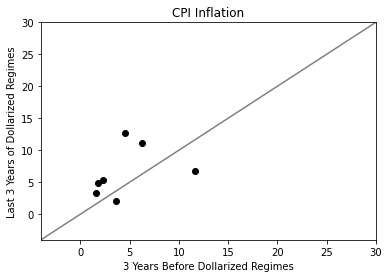

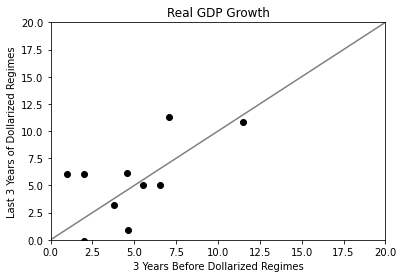

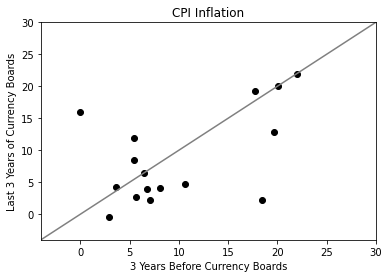

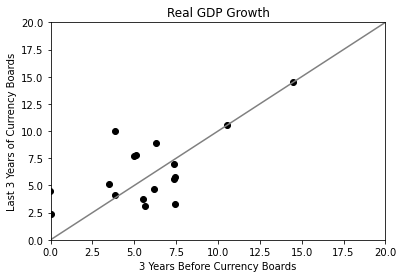

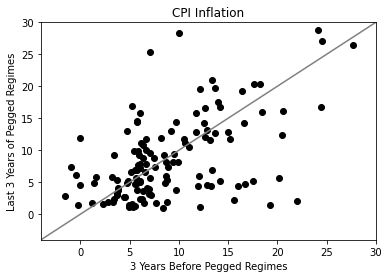

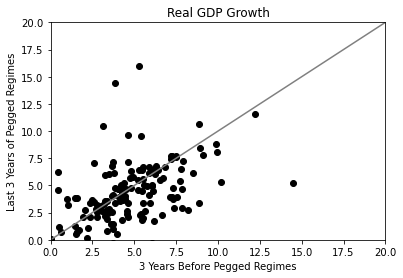

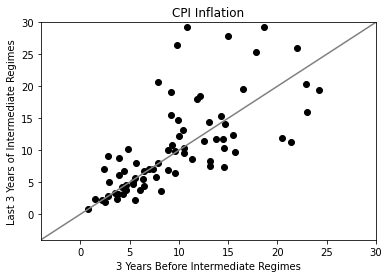

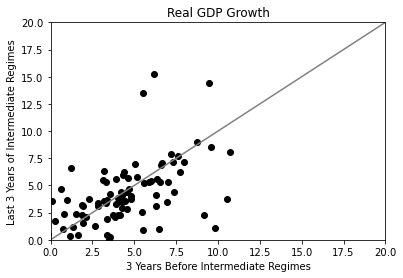

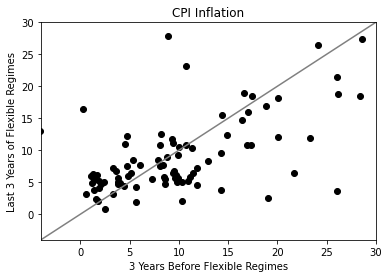

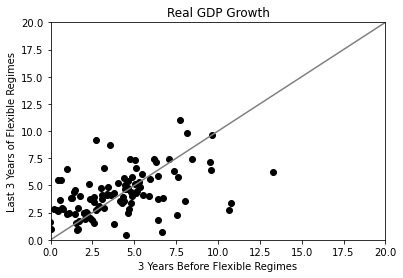

In [9]:
regime_dict = {'DOLLAR':'Dollarized Regimes','CURRENCYBOARD':'Currency Boards','PEGGED': 'Pegged Regimes','INTERMEDIATE': 'Intermediate Regimes','FLEXIBLE':'Flexible Regimes'}
for regime,name in regime_dict.items():

    PCPIPCH_before_series = []
    PCPIPCH_final_series = []
    NGDP_RPCH_before_series = []
    NGDP_RPCH_final_series = []
    for country in country_code:
        PCPIPCH_before_series.append(dfFullData.loc[(dfFullData['NAM']==country)&(dfFullData['dumBefore'+regime]==1),'PCPIPCH'].mean())
        PCPIPCH_final_series.append(dfFullData.loc[(dfFullData['NAM']==country)&(dfFullData['dumFinal'+regime]==1),'PCPIPCH'].mean())
        NGDP_RPCH_before_series.append(dfFullData.loc[(dfFullData['NAM']==country)&(dfFullData['dumBefore'+regime]==1),'NGDP_RPCH'].mean())
        NGDP_RPCH_final_series.append(dfFullData.loc[(dfFullData['NAM']==country)&(dfFullData['dumFinal'+regime]==1),'NGDP_RPCH'].mean())

    #for i,(a,b) in enumerate(zip(PCPIPCH_before_CURRENCYBOARD_series,PCPIPCH_final_CURRENCYBOARD_series)):
        #print(country_code[i],a,b)

    # Create a figure and axes objects
    fig1, ax1 = plt.subplots()

    ax1.scatter(PCPIPCH_before_series, PCPIPCH_final_series, color = 'black')
    x = np.linspace(-4, 30, 100)
    ax1.plot(x, x, color='grey', linestyle='-')
    ax1.set_title('CPI Inflation')
    ax1.set_xlim(-4,30)
    ax1.set_ylim(-4,30)
    ax1.set_xlabel('3 Years Before '+name)
    ax1.set_ylabel('Last 3 Years of '+name)
    ax1.get_figure().savefig('images/'+regime+'_CPI_inflation.png',dpi=300)


    fig2, ax2 = plt.subplots()

    ax2.scatter(NGDP_RPCH_before_series, NGDP_RPCH_final_series, color='black')
    x = np.linspace(0, 20, 100)
    ax2.plot(x, x, color='grey', linestyle='-')
    ax2.set_title('Real GDP Growth')
    ax2.set_xlim(0,20)
    ax2.set_ylim(0,20)
    ax2.set_xlabel('3 Years Before '+name)
    ax2.set_ylabel('Last 3 Years of '+name)
    ax2.get_figure().savefig('images/'+regime+'_Real_GDP.png',dpi=300)

    # Display the plot
    plt.show()  

# Section 3: Money Growth and Inflation Under Different Exchange Rate Regimes

[0.08684652 2.25848166]


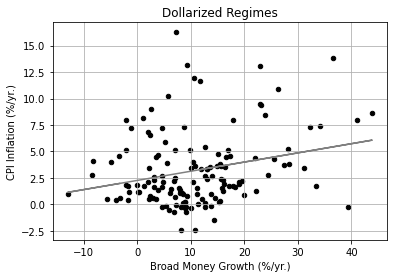

[0.2215609  2.20348716]


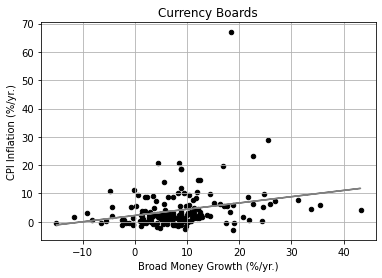

[0.33263427 3.78828996]


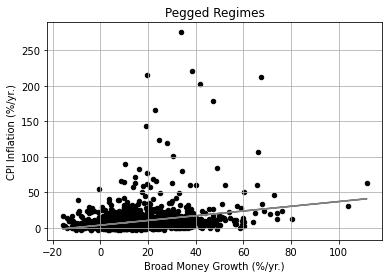

[0.51621481 3.83155497]


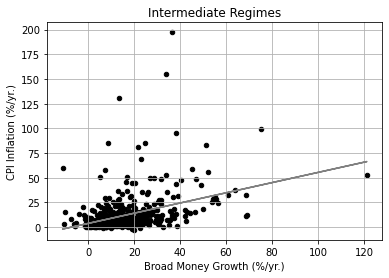

[0.57457041 1.73869113]


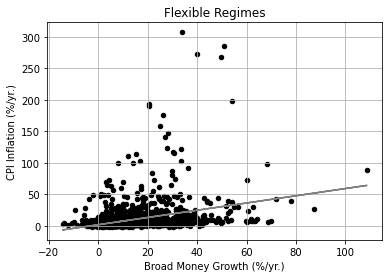

In [10]:
regime_dict = {'DOLLAR':'Dollarized Regimes','CURRENCYBOARD':'Currency Boards','PEGGED': 'Pegged Regimes','INTERMEDIATE': 'Intermediate Regimes','FLEXIBLE':'Flexible Regimes'}
for regime,name in regime_dict.items():

    dfTesting.loc[dfTesting['dum'+regime]==1,:].plot.scatter(x='FMBPCH', y='PCPIPCH', color='black', marker='o', s=20)
    dfPlot = dfTesting[['dum'+regime,'FMBPCH','PCPIPCH']].dropna()
    x = dfPlot.loc[dfTesting['dum'+regime]==1,'FMBPCH']
    y = dfPlot.loc[dfTesting['dum'+regime]==1,'PCPIPCH']
    coefficients = np.polyfit(x,y, 1)
    print(coefficients)
    poly = np.poly1d(coefficients)
    plt.plot(x, poly(x), color='grey', label='Best Fit Line')

    plt.xlabel('Broad Money Growth (%/yr.)')
    plt.ylabel('CPI Inflation (%/yr.)')
    plt.title(name)
    plt.grid(True)
    plt.savefig('images/'+regime+'Scatter.png',dpi=300)
    plt.show()

In [11]:
# Create year and country dummy variables 
# (except US (111) and year 2000 to avoid multicollinearity)

dumYRSList = []
for year in range(start_year,end_year+1):
    dfTesting['dumYRS'+str(year)] = 0
    dfTesting.loc[dfTesting['YRS']==year,'dumYRS'+str(year)] = 1
    if year != 2000:
        dumYRSList.append('dumYRS'+str(year))
    
dumNAMList = []
for country in set(dfTesting['NAM']):
    dfTesting['dumNAM'+str(country)] = 0
    dfTesting.loc[dfTesting['NAM']==country,'dumNAM'+str(country)] = 1
    if country != 111:
        dumNAMList.append('dumNAM'+str(country))
    
dfTesting

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfTesting['dumNAM'+str(country)] = 0
/var/folders/x6/57ghq8v93_b4q7bp0mscrhqw0000gn/T/ipykernel_66038/362374962.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

,NAM,YRS,REG,REG_SKIP,NGDP_R,NGDP_R_HP,NGDP_R_LN,NGDP_R_LN_GAP,NGDP_R_LN_HP,NGDP_RPCH,...,dumNAM453,dumNAM964,dumNAM967,dumNAM456,dumNAM968,dumNAM463,dumNAM466,dumNAM469,dumNAM474,dumNAM487
1,111,1971,3.0,3.0,5491.4455,5524.546653,8.610947,0.010061,8.621008,3.292726,...,0,0,0,0,0,0,0,0,0,0
2,111,1972,3.0,3.0,5780.0483,5711.074540,8.662167,-0.010326,8.651841,5.255498,...,0,0,0,0,0,0,0,0,0,0
3,111,1973,5.0,NaN,6106.3705,5896.843149,8.717088,-0.034744,8.682343,5.645666,...,0,0,0,0,0,0,0,0,0,0
4,111,1974,5.0,NaN,6073.3628,6081.997072,8.711668,0.000735,8.712403,-0.540545,...,0,0,0,0,0,0,0,0,0,0
5,111,1975,5.0,NaN,6060.8753,6268.776176,8.709610,0.032644,8.742253,-0.205611,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10578,968,2018,3.0,NaN,840.7860,NaN,6.734337,NaN,NaN,6.029000,...,0,0,0,0,1,0,0,0,0,0
10579,968,2019,4.0,NaN,873.1830,NaN,6.772145,NaN,NaN,3.853000,...,0,0,0,0,1,0,0,0,0,0
10580,968,2020,4.0,NaN,841.0720,NaN,6.734677,NaN,NaN,-3.677000,...,0,0,0,0,1,0,0,0,0,0
10581,968,2021,4.0,NaN,889.0880,NaN,6.790196,NaN,NaN,5.709000,...,0,0,0,0,1,0,0,0,0,0


# Section 4: Inflation under Alternative Exchange Rate Regimes — Panel Data Regression

In [12]:
# Conditioned on Broad Money Growth (FMBPCH) 
dfTesting_dropna = dfTesting[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             43
dumCURRENCYBOARD      73
dumPEGGED            260
dumINTERMEDIATE      160
dumFLEXIBLE         1096
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     20.26
Date:                Thu, 02 May 2024   Prob (F-statistic):          2.19e-140
Time:                        15:43:13   Log-Likelihood:                -4298.5
No. Observations:                1632   AIC:                             8705.
Df Residuals:                    1578   BIC:                             8996.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [13]:
# Conditioned on Broad Money Growth (FMBPCH) - Upper/Upper-mid income
dfUpperIncome = dfTesting.loc[(dfTesting['dumUpper']==1) | (dfTesting['dumUpper-mid']==1),:]
dfTesting_dropna = dfUpperIncome[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             3
dumCURRENCYBOARD     31
dumPEGGED           108
dumINTERMEDIATE      28
dumFLEXIBLE         722
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     16.80
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.71e-97
Time:                        15:43:13   Log-Likelihood:                -2066.5
No. Observations:                 892   AIC:                             4239.
Df Residuals:                     839   BIC:                             4493.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [14]:
# Conditioned on Broad Money Growth (FMBPCH) - Lower/lower-mid income
dfLowerIncome = dfTesting.loc[(dfTesting['dumLower']==1) | (dfTesting['dumLower-mid']==1),:]
dfTesting_dropna = dfLowerIncome[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            40
dumCURRENCYBOARD     42
dumPEGGED           152
dumINTERMEDIATE     132
dumFLEXIBLE         374
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     9.947
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.14e-51
Time:                        15:43:13   Log-Likelihood:                -2050.4
No. Observations:                 740   AIC:                             4197.
Df Residuals:                     692   BIC:                             4418.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [15]:
# Conditioned on Broad Money Growth (FMBPCH) - No currency control
dfNoCURCON = dfTesting.loc[dfTesting['CURCON']==0,:]
dfTesting_dropna = dfNoCURCON[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            34
dumCURRENCYBOARD     39
dumPEGGED           105
dumINTERMEDIATE      80
dumFLEXIBLE         732
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     19.30
Date:                Thu, 02 May 2024   Prob (F-statistic):           4.49e-82
Time:                        15:43:13   Log-Likelihood:                -2176.6
No. Observations:                 990   AIC:                             4419.
Df Residuals:                     957   BIC:                             4581.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [16]:
# Conditioned on Broad Money Growth (FMBPCH) - No capital control
dfNoKAPCON = dfTesting.loc[dfTesting['KAPCON']==0,:]
dfTesting_dropna = dfNoKAPCON[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            38
dumCURRENCYBOARD     57
dumPEGGED           117
dumINTERMEDIATE      83
dumFLEXIBLE         770
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     12.38
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.12e-75
Time:                        15:43:13   Log-Likelihood:                -2334.4
No. Observations:                1065   AIC:                             4773.
Df Residuals:                    1013   BIC:                             5031.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [17]:
# Unconditioned on Broad Money Growth (FMBPCH)
dfTesting_dropna = dfTesting[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             43
dumCURRENCYBOARD      73
dumPEGGED            260
dumINTERMEDIATE      160
dumFLEXIBLE         1096
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     7.513
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.29e-46
Time:                        15:43:13   Log-Likelihood:                -4541.5
No. Observations:                1632   AIC:                             9189.
Df Residuals:                    1579   BIC:                             9475.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [18]:
# Unconditioned on Broad Money Growth (FMBPCH) - Upper/Upper-mid income
dfUpperIncome = dfTesting.loc[(dfTesting['dumUpper']==1) | (dfTesting['dumUpper-mid']==1),:]
dfTesting_dropna = dfUpperIncome[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             3
dumCURRENCYBOARD     31
dumPEGGED           108
dumINTERMEDIATE      28
dumFLEXIBLE         722
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     7.633
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.92e-42
Time:                        15:43:13   Log-Likelihood:                -2214.9
No. Observations:                 892   AIC:                             4534.
Df Residuals:                     840   BIC:                             4783.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [19]:
# Unconditioned on Broad Money Growth (FMBPCH) - Lower/lower-mid income
dfLowerIncome = dfTesting.loc[(dfTesting['dumLower']==1) | (dfTesting['dumLower-mid']==1),:]
dfTesting_dropna = dfLowerIncome[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            40
dumCURRENCYBOARD     42
dumPEGGED           152
dumINTERMEDIATE     132
dumFLEXIBLE         374
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     4.112
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.64e-16
Time:                        15:43:13   Log-Likelihood:                -2152.1
No. Observations:                 740   AIC:                             4398.
Df Residuals:                     693   BIC:                             4615.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [20]:
# Unconditioned on Broad Money Growth (FMBPCH) - No currency control
dfNoCURCON = dfTesting.loc[dfTesting['CURCON']==0,:]
dfTesting_dropna = dfNoCURCON[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            34
dumCURRENCYBOARD     39
dumPEGGED           105
dumINTERMEDIATE      80
dumFLEXIBLE         732
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     12.31
Date:                Thu, 02 May 2024   Prob (F-statistic):           6.57e-51
Time:                        15:43:13   Log-Likelihood:                -2257.0
No. Observations:                 990   AIC:                             4578.
Df Residuals:                     958   BIC:                             4735.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [21]:
# Unconditioned on Broad Money Growth (FMBPCH) - No capital control
dfNoKAPCON = dfTesting.loc[dfTesting['KAPCON']==0,:]
dfTesting_dropna = dfNoKAPCON[['PCPIPCH_X','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            38
dumCURRENCYBOARD     57
dumPEGGED           117
dumINTERMEDIATE      83
dumFLEXIBLE         770
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     9.724
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.71e-57
Time:                        15:43:13   Log-Likelihood:                -2383.8
No. Observations:                1065   AIC:                             4870.
Df Residuals:                    1014   BIC:                             5123.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [22]:
# SKIP First 3 years, Conditioned on Broad Money Growth (FMBPCH) 
dfTesting_dropna = dfTesting[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            41
dumCURRENCYBOARD_SKIP     72
dumPEGGED_SKIP           173
dumINTERMEDIATE_SKIP      80
dumFLEXIBLE_SKIP         974
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     20.78
Date:                Thu, 02 May 2024   Prob (F-statistic):          8.39e-144
Time:                        15:43:13   Log-Likelihood:                -4289.9
No. Observations:                1632   AIC:                             8688.
Df Residuals:                    1578   BIC:                             8979.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [23]:
# SKIP First 3 years, Conditioned on Broad Money Growth (FMBPCH) - Upper/Upper-mid income
dfUpperIncome = dfTesting.loc[(dfTesting['dumUpper']==1) | (dfTesting['dumUpper-mid']==1),:]
dfTesting_dropna = dfUpperIncome[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP             3
dumCURRENCYBOARD_SKIP     30
dumPEGGED_SKIP            90
dumINTERMEDIATE_SKIP      11
dumFLEXIBLE_SKIP         676
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     16.52
Date:                Thu, 02 May 2024   Prob (F-statistic):           7.71e-96
Time:                        15:43:14   Log-Likelihood:                -2070.3
No. Observations:                 892   AIC:                             4247.
Df Residuals:                     839   BIC:                             4501.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [24]:
# SKIP First 3 years, Conditioned on Broad Money Growth (FMBPCH) - Lower/Lower-mid income
dfLowerIncome = dfTesting.loc[(dfTesting['dumLower']==1) | (dfTesting['dumLower-mid']==1),:]
dfTesting_dropna = dfLowerIncome[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            38
dumCURRENCYBOARD_SKIP     42
dumPEGGED_SKIP            83
dumINTERMEDIATE_SKIP      69
dumFLEXIBLE_SKIP         298
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     9.700
Date:                Thu, 02 May 2024   Prob (F-statistic):           4.94e-50
Time:                        15:43:14   Log-Likelihood:                -2054.1
No. Observations:                 740   AIC:                             4204.
Df Residuals:                     692   BIC:                             4425.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [25]:
# SKIP First 3 years, Conditioned on Broad Money Growth (FMBPCH) - No currency control
dfNoCURCON = dfTesting.loc[dfTesting['CURCON']==0,:]
dfTesting_dropna = dfNoCURCON[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            32
dumCURRENCYBOARD_SKIP     39
dumPEGGED_SKIP            68
dumINTERMEDIATE_SKIP      45
dumFLEXIBLE_SKIP         666
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     18.99
Date:                Thu, 02 May 2024   Prob (F-statistic):           7.40e-81
Time:                        15:43:14   Log-Likelihood:                -2179.6
No. Observations:                 990   AIC:                             4425.
Df Residuals:                     957   BIC:                             4587.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [26]:
# SKIP First 3 years, Conditioned on Broad Money Growth (FMBPCH) - No capital control
dfNoKAPCON = dfTesting.loc[dfTesting['KAPCON']==0,:]
dfTesting_dropna = dfNoKAPCON[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            36
dumCURRENCYBOARD_SKIP     56
dumPEGGED_SKIP            85
dumINTERMEDIATE_SKIP      46
dumFLEXIBLE_SKIP         708
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     12.98
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.78e-79
Time:                        15:43:14   Log-Likelihood:                -2324.6
No. Observations:                1065   AIC:                             4753.
Df Residuals:                    1013   BIC:                             5012.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [27]:
# SKIP First 3 years, Unconditioned on Broad Money Growth (FMBPCH) 
dfTesting_dropna = dfTesting[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            41
dumCURRENCYBOARD_SKIP     72
dumPEGGED_SKIP           173
dumINTERMEDIATE_SKIP      80
dumFLEXIBLE_SKIP         974
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     8.292
Date:                Thu, 02 May 2024   Prob (F-statistic):           9.56e-53
Time:                        15:43:14   Log-Likelihood:                -4524.9
No. Observations:                1632   AIC:                             9156.
Df Residuals:                    1579   BIC:                             9442.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [28]:
# SKIP First 3 years, Unconditioned on Broad Money Growth (FMBPCH) - Upper/Upper-mid income
dfUpperIncome = dfTesting.loc[(dfTesting['dumUpper']==1) | (dfTesting['dumUpper-mid']==1),:]
dfTesting_dropna = dfUpperIncome[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP             3
dumCURRENCYBOARD_SKIP     30
dumPEGGED_SKIP            90
dumINTERMEDIATE_SKIP      11
dumFLEXIBLE_SKIP         676
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     7.178
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.13e-39
Time:                        15:43:14   Log-Likelihood:                -2223.4
No. Observations:                 892   AIC:                             4551.
Df Residuals:                     840   BIC:                             4800.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [29]:
# SKIP First 3 years, Unconditioned on Broad Money Growth (FMBPCH) - Lower/Lower-mid income
dfLowerIncome = dfTesting.loc[(dfTesting['dumLower']==1) | (dfTesting['dumLower-mid']==1),:]
dfTesting_dropna = dfLowerIncome[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            38
dumCURRENCYBOARD_SKIP     42
dumPEGGED_SKIP            83
dumINTERMEDIATE_SKIP      69
dumFLEXIBLE_SKIP         298
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.076
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.74e-16
Time:                        15:43:14   Log-Likelihood:                -2152.8
No. Observations:                 740   AIC:                             4400.
Df Residuals:                     693   BIC:                             4616.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [30]:
# SKIP First 3 years, Unconditioned on Broad Money Growth (FMBPCH) - No currency control
dfNoCURCON = dfTesting.loc[dfTesting['CURCON']==0,:]
dfTesting_dropna = dfNoCURCON[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            32
dumCURRENCYBOARD_SKIP     39
dumPEGGED_SKIP            68
dumINTERMEDIATE_SKIP      45
dumFLEXIBLE_SKIP         666
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     12.90
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.58e-53
Time:                        15:43:14   Log-Likelihood:                -2250.3
No. Observations:                 990   AIC:                             4565.
Df Residuals:                     958   BIC:                             4721.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [31]:
# SKIP First 3 years, Unconditioned on Broad Money Growth (FMBPCH) - No capital control
dfNoKAPCON = dfTesting.loc[dfTesting['KAPCON']==0,:]
dfTesting_dropna = dfNoKAPCON[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            36
dumCURRENCYBOARD_SKIP     56
dumPEGGED_SKIP            85
dumINTERMEDIATE_SKIP      46
dumFLEXIBLE_SKIP         708
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     10.56
Date:                Thu, 02 May 2024   Prob (F-statistic):           8.61e-63
Time:                        15:43:14   Log-Likelihood:                -2369.1
No. Observations:                1065   AIC:                             4840.
Df Residuals:                    1014   BIC:                             5094.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [32]:
# SKIP First 3 years, Conditioned on Broad Money Growth (FMBPCH), country-fixed effects
dfTesting_dropna = dfTesting[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList+dumNAMList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList+dumNAMList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            41
dumCURRENCYBOARD_SKIP     72
dumPEGGED_SKIP           173
dumINTERMEDIATE_SKIP      80
dumFLEXIBLE_SKIP         974
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     19.48
Date:                Thu, 02 May 2024   Prob (F-statistic):          1.42e-243
Time:                        15:43:14   Log-Likelihood:                -3898.4
No. Observations:                1632   AIC:                             8067.
Df Residuals:                    1497   BIC:                             8795.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

# Section 5: Real Export Growth Under Alternative Regimes

In [33]:
# SKIP First 3 years, Unconditioned on Broad Money Growth (FMBPCH), country-fixed effects
dfTesting_dropna = dfTesting[['PCPIPCH_X','dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','FMBPCH','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList+dumNAMList].dropna()
print(dfTesting_dropna[['dumDOLLAR_SKIP','dumCURRENCYBOARD_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP']].sum(0))
X = dfTesting_dropna[['dumDOLLAR_SKIP','dumPEGGED_SKIP','dumINTERMEDIATE_SKIP','dumFLEXIBLE_SKIP','NGDP_RPCH','OPEN','CBTURN5','TTPCH','GGSB_NPGDP']+dumYRSList+dumNAMList]
Y = dfTesting_dropna['PCPIPCH_X']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR_SKIP            41
dumCURRENCYBOARD_SKIP     72
dumPEGGED_SKIP           173
dumINTERMEDIATE_SKIP      80
dumFLEXIBLE_SKIP         974
dtype: int64
                            OLS Regression Results                            
Dep. Variable:              PCPIPCH_X   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.11
Date:                Thu, 02 May 2024   Prob (F-statistic):          5.97e-218
Time:                        15:43:15   Log-Likelihood:                -3968.0
No. Observations:                1632   AIC:                             8204.
Df Residuals:                    1498   BIC:                             8927.
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                           coef    std err          

In [34]:
# Export Growth
dfTesting_dropna = dfTesting[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             59
dumCURRENCYBOARD     148
dumPEGGED           1585
dumINTERMEDIATE      501
dumFLEXIBLE         1808
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     8.409
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.35e-55
Time:                        15:43:15   Log-Likelihood:                -17068.
No. Observations:                4180   AIC:                         3.424e+04
Df Residuals:                    4130   BIC:                         3.455e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [35]:
# Export Growth (Upper/Upper-middle income)
dfUpperIncome = dfTesting.loc[(dfTesting['dumUpper']==1) | (dfTesting['dumUpper-mid']==1),:]
dfTesting_dropna = dfUpperIncome[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            19
dumCURRENCYBOARD     58
dumPEGGED           357
dumINTERMEDIATE      79
dumFLEXIBLE         834
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.534
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.10e-28
Time:                        15:43:15   Log-Likelihood:                -5149.6
No. Observations:                1357   AIC:                         1.040e+04
Df Residuals:                    1308   BIC:                         1.065e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [36]:
# Export Growth (Lower/Lower-middle income)
dfLowerIncome = dfTesting.loc[(dfTesting['dumLower']==1) | (dfTesting['dumLower-mid']==1),:]
dfTesting_dropna = dfLowerIncome[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             40
dumCURRENCYBOARD      90
dumPEGGED           1228
dumINTERMEDIATE      422
dumFLEXIBLE          974
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     5.475
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.34e-30
Time:                        15:43:15   Log-Likelihood:                -11768.
No. Observations:                2823   AIC:                         2.364e+04
Df Residuals:                    2773   BIC:                         2.393e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [37]:
# Export Growth (Countries with no current account control)
dfNoCURCON = dfTesting.loc[dfTesting['CURCON']==0,:]
dfTesting_dropna = dfNoCURCON[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            34
dumCURRENCYBOARD     68
dumPEGGED           209
dumINTERMEDIATE     165
dumFLEXIBLE         922
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.11
Date:                Thu, 02 May 2024   Prob (F-statistic):           5.73e-53
Time:                        15:43:15   Log-Likelihood:                -5176.7
No. Observations:                1398   AIC:                         1.041e+04
Df Residuals:                    1369   BIC:                         1.056e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [38]:
# Export Growth (Countries with no capital account control)
dfNoKAPCON = dfTesting.loc[dfTesting['KAPCON']==0,:]
dfTesting_dropna = dfNoKAPCON[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             54
dumCURRENCYBOARD      85
dumPEGGED            308
dumINTERMEDIATE      200
dumFLEXIBLE         1014
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     7.953
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.45e-46
Time:                        15:43:15   Log-Likelihood:                -6414.8
No. Observations:                1661   AIC:                         1.293e+04
Df Residuals:                    1613   BIC:                         1.319e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [39]:
# Export Growth (Unconditional on real exchange rate)
dfTesting_dropna = dfTesting[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             59
dumCURRENCYBOARD     148
dumPEGGED           1585
dumINTERMEDIATE      501
dumFLEXIBLE         1808
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     8.433
Date:                Thu, 02 May 2024   Prob (F-statistic):           8.90e-55
Time:                        15:43:15   Log-Likelihood:                -17072.
No. Observations:                4180   AIC:                         3.424e+04
Df Residuals:                    4131   BIC:                         3.455e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [40]:
# Export Growth (Upper/Upper-middle income) (Unconditional on real exchange rate)
dfUpperIncome = dfTesting.loc[(dfTesting['dumUpper']==1) | (dfTesting['dumUpper-mid']==1),:]
dfTesting_dropna = dfUpperIncome[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            19
dumCURRENCYBOARD     58
dumPEGGED           357
dumINTERMEDIATE      79
dumFLEXIBLE         834
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.622
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.54e-28
Time:                        15:43:15   Log-Likelihood:                -5150.3
No. Observations:                1357   AIC:                         1.040e+04
Df Residuals:                    1309   BIC:                         1.065e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [41]:
# Export Growth (Lower/Lower-middle income) (Unconditional on real exchange rate)
dfLowerIncome = dfTesting.loc[(dfTesting['dumLower']==1) | (dfTesting['dumLower-mid']==1),:]
dfTesting_dropna = dfLowerIncome[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             40
dumCURRENCYBOARD      90
dumPEGGED           1228
dumINTERMEDIATE      422
dumFLEXIBLE          974
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     5.435
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.36e-29
Time:                        15:43:15   Log-Likelihood:                -11772.
No. Observations:                2823   AIC:                         2.364e+04
Df Residuals:                    2774   BIC:                         2.393e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

In [42]:
# Export Growth (Countries with no current account control) (Unconditional on real exchange rate)
dfNoCURCON = dfTesting.loc[dfTesting['CURCON']==0,:]
dfTesting_dropna = dfNoCURCON[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR            34
dumCURRENCYBOARD     68
dumPEGGED           209
dumINTERMEDIATE     165
dumFLEXIBLE         922
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     13.32
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.67e-52
Time:                        15:43:15   Log-Likelihood:                -5179.8
No. Observations:                1398   AIC:                         1.042e+04
Df Residuals:                    1370   BIC:                         1.056e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      

In [43]:
# Export Growth (Countries with no capital account control) (Unconditional on real exchange rate)
dfNoKAPCON = dfTesting.loc[dfTesting['KAPCON']==0,:]
dfTesting_dropna = dfNoKAPCON[['TX_RPCH','dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','REERAOPPCH','WGDP_RPCH','TTPCH.L1']+dumYRSList].dropna()
print(dfTesting_dropna[['dumDOLLAR','dumCURRENCYBOARD','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE']].sum(0))
X = dfTesting_dropna[['dumDOLLAR','dumPEGGED','dumINTERMEDIATE','dumFLEXIBLE','WGDP_RPCH','TTPCH.L1']+dumYRSList]
Y = dfTesting_dropna['TX_RPCH']
X_with_const = sm.add_constant(X)
model = sm.OLS(Y,X_with_const)
results = model.fit()

# Display the summary which includes t-statistics
print(results.summary())

dumDOLLAR             54
dumCURRENCYBOARD      85
dumPEGGED            308
dumINTERMEDIATE      200
dumFLEXIBLE         1014
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                TX_RPCH   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     8.042
Date:                Thu, 02 May 2024   Prob (F-statistic):           5.26e-46
Time:                        15:43:15   Log-Likelihood:                -6416.5
No. Observations:                1661   AIC:                         1.293e+04
Df Residuals:                    1614   BIC:                         1.318e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025 

# Disinflation test
country_code = sorted(list(set(dfTesting['NAM'])))
dfTesting[['dumLowPCPIdisinflation','dumModeratePCPIPCHdisinflation','dumHighPCPIPCHdisinflation']] = 0
dfTesting[['dumLowPCPIsuccess','dumModeratePCPIPCHsuccess','dumHighPCPIPCHsuccess']] = 0
dfTesting[['dumLowPCPIdurable','dumModeratePCPIPCHdurable','dumHighPCPIPCHdurable']] = 0
for country in country_code:
    for year in range(start_year+2,end_year-2):
        index = 
        if (dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year),'PCPIPCH'])
        print(dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year-2),'PCPIPCH'].values[0])
        if (dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year-2),'PCPIPCH'].values > 20) and (
            dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year),'PCPIPCH'] - dfTesting.loc[dfTesting['YRS']==year-2,'PCPIPCH'] < -5):
            dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year),'dumLowPCPIdisinflation'] = 1
            if dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+1),'PCPIPCH'] < dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year-2),'PCPIPCH']:
                dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+1),'dumLowPCPIsuccess'] = 1
            if dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+1),'PCPIPCH'] < dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year),'PCPIPCH']:
                dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+1),'dumLowPCPIdurable'] = 1
            if dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+2),'PCPIPCH'] < dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year-2),'PCPIPCH']:
                dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+2),'dumLowPCPIsuccess'] = 1
            if dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+2),'PCPIPCH'] < dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year),'PCPIPCH']:
                dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+2),'dumLowPCPIdurable'] = 1
            if dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+3),'PCPIPCH'] < dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year-2),'PCPIPCH']:
                dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+3),'dumLowPCPIsuccess'] = 1
            if dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+3),'PCPIPCH'] < dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year),'PCPIPCH']:
                dfTesting.loc[(dfTesting['NAM']==country)&(dfTesting['YRS']==year+3),'dumLowPCPIdurable'] = 1
dfTesting[['dumLowPCPIdisinflation','dumModeratePCPIPCHdisinflation','dumHighPCPIPCHdisinflation']]           